In [15]:
import torch
import torch.nn as nn
import numpy as np

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode_with_batch
from src.utils.viz import  display_convnode_trajectory

from src.models.convnode import ConvNodeWithBatch, LatentRegularizerLoss


In [25]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 500
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)
print(images.shape)


--------------------------------------------------
Generating images...


100%|██████████| 500/500 [00:15<00:00, 32.27it/s]


(150500, 1, 28, 28)
torch.Size([500, 301, 3, 28, 28])


In [26]:
print("-"*50)
print("Creating model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 28
latent_dim = 25
in_channels = 3
ode_data_dim = 25
ode_hidden_dim = 128
augment_dim=0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

conv_ode = ConvNodeWithBatch(device, size, latent_dim, in_channels,
    ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
    ode_non_linearity=ode_non_linearity, conv_activation=conv_activation,
    latent_activation=latent_activation, stack_size=stack_size)

pathConvODE = "models/AE_ODE/ConvODE/conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
print(conv_ode.load_state_dict(torch.load(pathConvODE)))

--------------------------------------------------
Creating model...
--------------------------------------------------
Creating ConvAE...
Number of parameters in the encoder model: 137945
Number of parameters in the decoder model: 138083
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 30765
<All keys matched successfully>


In [27]:
print("-"*50)
print("Creating tools to train...")
batch_size = 8
batch_time = 100
n_stack = 1
total_length = N_frames - Num_pos_velocity
getter = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images, frac_train=1.)

reg_lambda = 1e-3
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
loss_fn = LatentRegularizerLoss(device, reg_lambda, step_decay=1000, decay_rate=0.9)

--------------------------------------------------
Creating tools to train...


In [28]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)

--------------------------------------------------
Training...


  5%|▍         | 499/10000 [01:39<31:33,  5.02it/s, Loss: 0.00091716]/Users/maximebonnin/Documents/X/3A/Stage/IntNeuralODE/src/utils/viz.py:216: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Display loss: 0.00085583:   5%|▌         | 500/10000 [01:39<35:33,  4.45it/s, Loss: 0.00091716]

The graphs at epoch 500
------------------------------
loss_img:  tensor(0.0005, grad_fn=<MseLossBackward>)
loss_reg:  tensor(0.0004, grad_fn=<MulBackward0>)
reg_lambda:  0.001
------------------------------


Display loss: 0.00085583:   8%|▊         | 783/10000 [02:35<30:31,  5.03it/s, Loss: 0.00063773]


KeyboardInterrupt: 

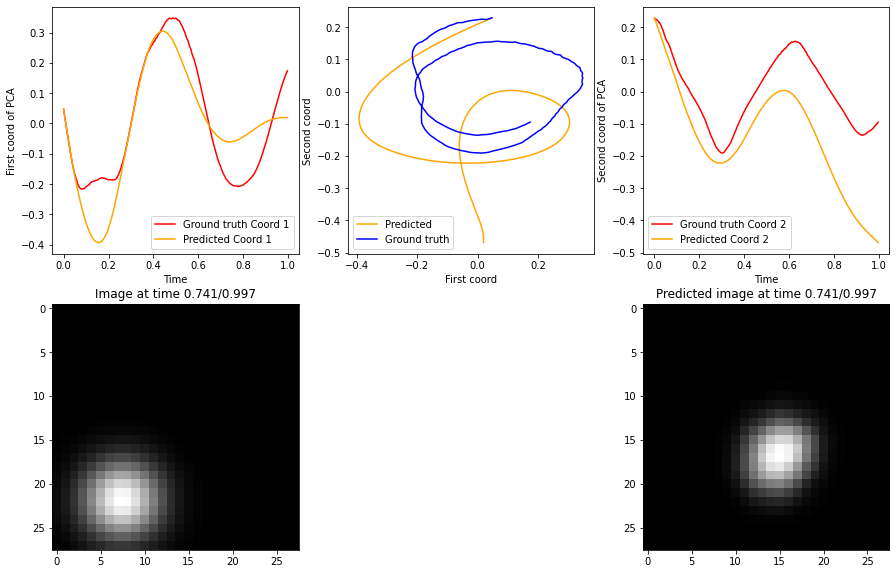

In [29]:
print("-"*50)
print("Training...")
batch_size = 32
epochs = 10000
train_convnode_with_batch(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=500, display_results_fn=display_fn)